In [302]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb

#### Output file

In [303]:
sourceFile = open("gpu_logs/ensemble.txt", 'w')

### Load the data

In [304]:
df = pd.read_pickle("../datasets/df_location.pkl")
number_of_houses = 50
num_samples_per_house = 35136
df.reset_index(drop=True, inplace=True)
## Leaving the first house (public building out) due to its different profile
df = df.iloc[35136:, [0, 2, 1]].reset_index(drop=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,1,2.322959
1,2019-01-01 00:15:00,1,2.371797
2,2019-01-01 00:30:00,1,2.415961
3,2019-01-01 00:45:00,1,2.302538
4,2019-01-01 01:00:00,1,2.363063
...,...,...,...
1756795,2020-01-01 22:45:00,50,0.753222
1756796,2020-01-01 23:00:00,50,0.716855
1756797,2020-01-01 23:15:00,50,0.735802
1756798,2020-01-01 23:30:00,50,0.485237


In [305]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [306]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    wape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    r2 = r2_score(actuals, preds)
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.4f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [307]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)


def last_energy_points(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = pd.DataFrame(df[number_timesteps:])
    y = y['Energy']
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    return X, y

def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [308]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [309]:
#scores = validate(xgb.XGBRegressor(seed=0), X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [310]:
number_of_timesteps = 12

In [311]:
df_new = last_energy_points_full(df, number_of_timesteps, num_samples_per_house)
df_new

,Time,Location,Energy_15,Energy_30,Energy_45,Energy_60,Energy_75,Energy_90,Energy_105,Energy_120,Energy_135,Energy_150,Energy_165,Energy_180,Energy
0,2019-01-01 03:00:00,1,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,2.406489
1,2019-01-01 03:15:00,1,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538,2.415961,2.371797,2.378686
2,2019-01-01 03:30:00,1,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538,2.415961,2.338582
3,2019-01-01 03:45:00,1,2.338582,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.302538,2.256406
4,2019-01-01 04:00:00,1,2.256406,2.338582,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299585,2.334031,2.363063,2.298232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756195,2020-01-01 22:45:00,50,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,0.552398,0.937120,0.753222
1756196,2020-01-01 23:00:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,0.552398,0.716855
1756197,2020-01-01 23:15:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.464143,0.735802
1756198,2020-01-01 23:30:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,0.533286,0.533451,0.485237


In [312]:
df_new.isna().sum()

Time          0
Location      0
Energy_15     0
Energy_30     0
Energy_45     0
Energy_60     0
Energy_75     0
Energy_90     0
Energy_105    0
Energy_120    0
Energy_135    0
Energy_150    0
Energy_165    0
Energy_180    0
Energy        0
dtype: int64

In [313]:
def test_leave_house_out(df, estimator, number_timesteps, num_houses_test, locations, filename):
    df_new = last_energy_points_full(df, number_timesteps, num_samples_per_house)
    df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
    df_new['Hour'] = df_new['Time'].dt.hour
    test = df_new[df_new['Location'].isin(locations)]
    train = df_new[~df_new['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

In [314]:
num_houses_test = 10

In [315]:
kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
locations = []
for _, test_index in kf.split(df['Location'].unique()):
    locations.append(test_index)
locations

[array([13, 17, 19, 25, 26, 30, 32, 39, 45, 48]),
 array([ 3,  4,  6,  8, 12, 15, 37, 41, 46, 47]),
 array([ 0,  5,  9, 16, 24, 27, 31, 33, 34, 44]),
 array([ 1,  2, 11, 21, 23, 29, 35, 36, 40, 43]),
 array([ 7, 10, 14, 18, 20, 22, 28, 38, 42, 49]),
 array([ 0,  2, 10, 22, 29, 38, 39, 44, 45, 46]),
 array([ 4, 12, 18, 21, 24, 30, 31, 32, 33, 49]),
 array([ 9, 14, 15, 20, 23, 26, 36, 40, 41, 42]),
 array([ 3,  5, 11, 16, 17, 28, 35, 37, 47, 48]),
 array([ 1,  6,  7,  8, 13, 19, 25, 27, 34, 43])]

In [316]:
locations = []
for i in range(10):
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array([20, 48,  7, 19,  1, 40, 39, 15,  4, 18]),
 array([29,  4, 13, 25, 27, 26, 21, 50, 43,  1]),
 array([27, 38, 46, 36, 49,  8, 43,  2, 25, 48]),
 array([39, 15, 41, 23, 13, 48, 27, 12, 16, 31]),
 array([ 4, 28, 29,  1, 30, 46, 48, 38, 19, 14]),
 array([10, 14, 36, 39, 42, 15, 41, 17, 32, 47]),
 array([45, 46, 32, 30, 36, 43, 29, 49, 33, 17]),
 array([20, 30, 14, 12, 48, 13, 42, 31, 40,  5]),
 array([12, 35, 20, 42, 38,  2, 25, 21, 43, 31]),
 array([35, 40, 13, 48, 11, 34,  8, 21,  5, 32])]

### Linear Regression

In [317]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)


### XGBoost

In [318]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)
Train set:  (1404960, 18)
Test set:  (351240, 18)


### Random Forest

In [319]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), number_of_timesteps, num_houses_test, locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (1404960, 18)
Test set:  (351240, 18)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [320]:
print("\n\n\n", file=sourceFile)

In [321]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [322]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [323]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

### Feature Importance

In [324]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 8.99801
Feature: 1, Score: -1.22476
Feature: 2, Score: 1.40355
Feature: 3, Score: -0.54625
Feature: 4, Score: 0.88743
Feature: 5, Score: 0.06343
Feature: 6, Score: 0.04582
Feature: 7, Score: -0.21591
Feature: 8, Score: 0.29139
Feature: 9, Score: 0.03014
Feature: 10, Score: 0.02695
Feature: 11, Score: -0.02069
Feature: 12, Score: 0.00919
Feature: 13, Score: -0.00432
Feature: 14, Score: 0.04420
XGBoost

Feature: 0, Score: 0.88034
Feature: 1, Score: 0.01385
Feature: 2, Score: 0.02010
Feature: 3, Score: 0.00780
Feature: 4, Score: 0.01416
Feature: 5, Score: 0.00987
Feature: 6, Score: 0.00756
Feature: 7, Score: 0.00613
Feature: 8, Score: 0.00666
Feature: 9, Score: 0.00567
Feature: 10, Score: 0.00538
Feature: 11, Score: 0.00670
Feature: 12, Score: 0.00489
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.01090


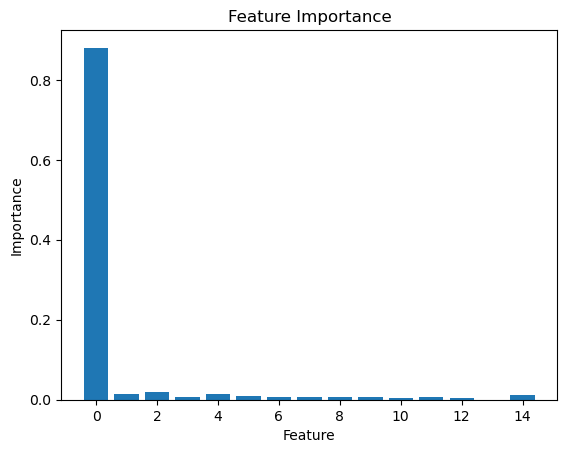

In [325]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

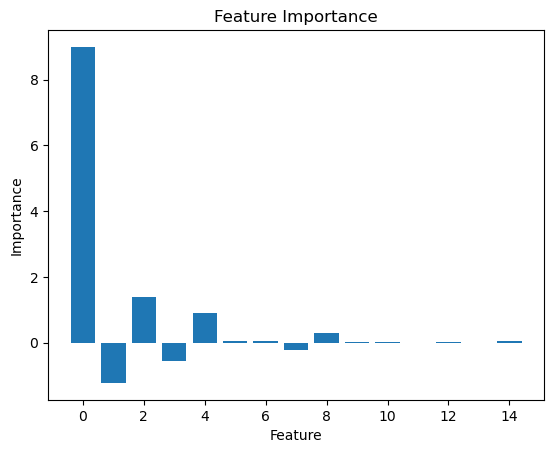

In [326]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [327]:
sourceFile.close()